# Import packages

In [1]:
import matplotlib.pyplot as plt #plots
import numpy as np #linear algebra
%matplotlib inline
import torch #Pytorch
import torch.nn as nn #Package that contains layers and functions needed to contruct a model

In [2]:
#Needed to load dataset
from tensorflow.keras.utils import get_file
from zipfile import ZipFile
from scipy import io as sio
import os
import logging
# Libraries needed for Handwritten dataset (some overlap a bit => should clean up matplotlib pyplot)
import os 
from PIL import Image, ImageOps
from sklearn import preprocessing

# EMNIST

In [4]:
#Loading, Reshaping and Normalization of dataset
# Source: https://github.com/machinecurve/extra_keras_datasets/blob/master/extra_keras_datasets/emnist.py

def load_data(path="emnist_matlab.npz", type="letters"):

    # Log about loading
    logging.basicConfig(level=logging.INFO)
    logging.info('Loading dataset = emnist')

    # Load data
    path = get_file(
        path, origin=("http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/"
                      "matlab.zip")
    )
    with ZipFile(path, "r") as opened_zip:

        # Read file and temporarily store it
        file_name = f"./{type}.mat"
        f = open(file_name, "wb")
        f.write(opened_zip.read(f"matlab/emnist-{type}.mat"))
        f.close()

        # Load data from Matlab file.
        # Source: https://stackoverflow.com/a/53547262
        mat = sio.loadmat(file_name)
        data = mat["dataset"]
        input_train = data["train"][0, 0]["images"][0, 0]
        target_train = data["train"][0, 0]["labels"][0, 0].flatten()
        input_test = data["test"][0, 0]["images"][0, 0]
        target_test = data["test"][0, 0]["labels"][0, 0].flatten()

        # Remove data when loaded
        os.remove(file_name)

        #Normalization of the data (Added this part, was not in original code)
        input_train = input_train / 255.0
        input_test = input_test / 255.0

        # Reshape input data (I changed it (n, 1, 28, 28, shape) as was in paper)
        # Source: https://stackoverflow.com/a/53547262
        input_train = input_train.reshape(
          (input_train.shape[0], 1, 28, 28), order="F"
        )
        input_test = input_test.reshape(
          (input_test.shape[0], 1, 28, 28), order="F"
        )

        # Return data
        return (input_train, target_train), (input_test, target_test)

In [6]:
#Loading the Emnist dataset as train, test and corresponding labels
(x_train, y_train), (x_test, y_test) = load_data()

INFO:root:Loading dataset = emnist


(124800, 1, 28, 28) (20800, 1, 28, 28) (124800,) (20800,)


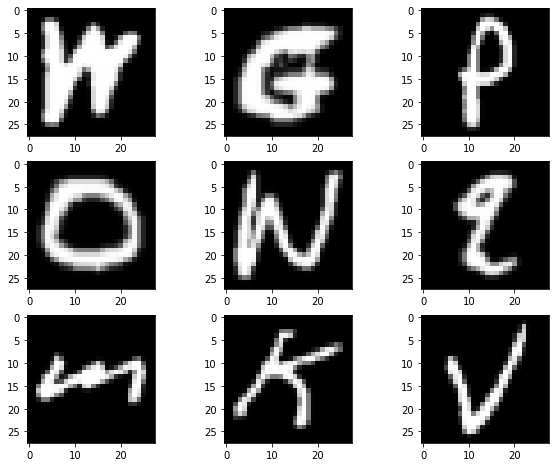

In [7]:
#Shapes of our data and plotting the digit image examples in gray
fig,axes = plt.subplots(3,3,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i].reshape([28,28]), cmap=plt.get_cmap('gray'))

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
#print(x_train[3])

In [8]:
# To load data from Handwritten Test 2 and Test 3
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Test 2

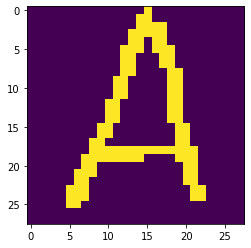

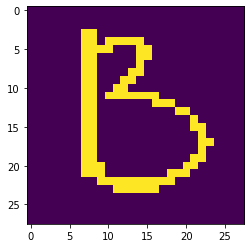

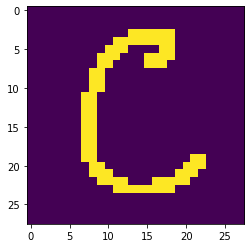

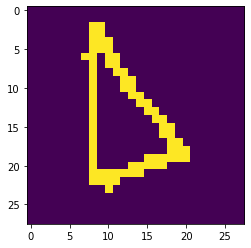

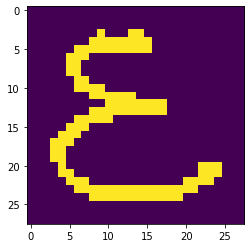

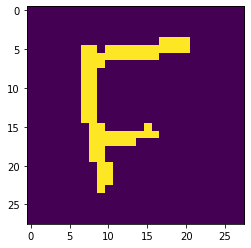

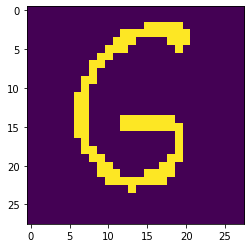

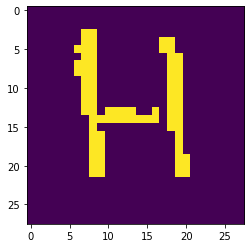

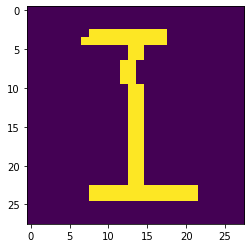

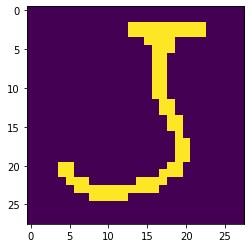

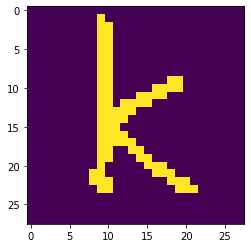

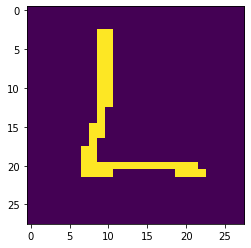

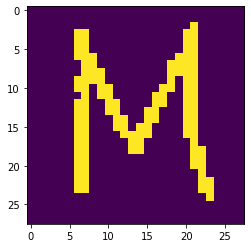

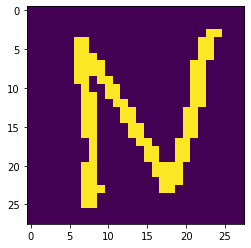

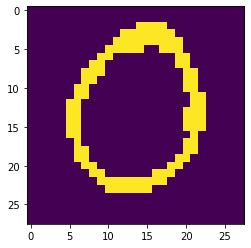

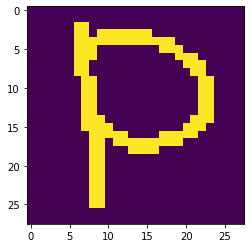

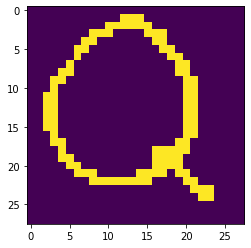

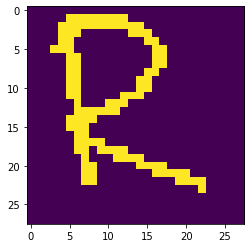

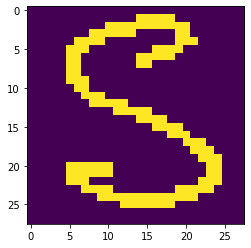

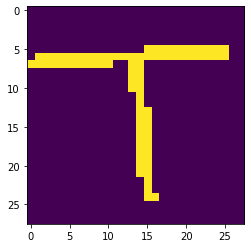

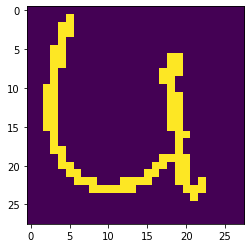

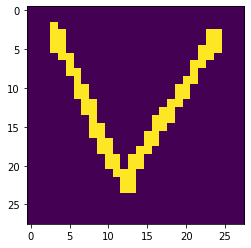

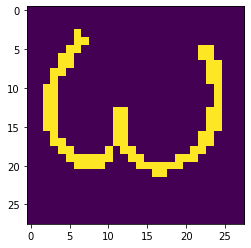

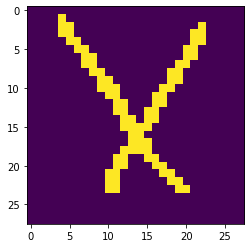

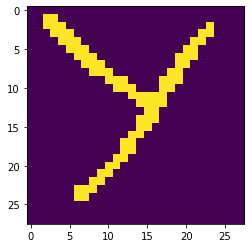

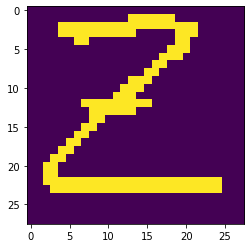

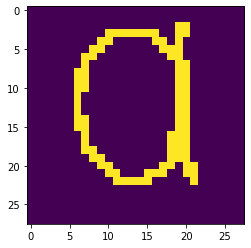

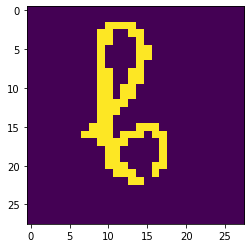

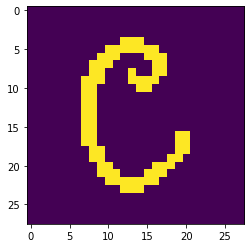

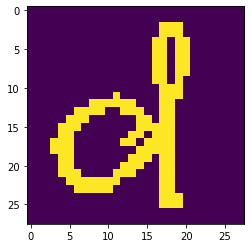

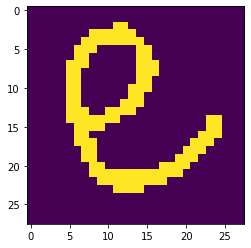

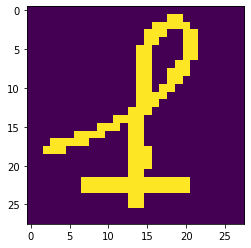

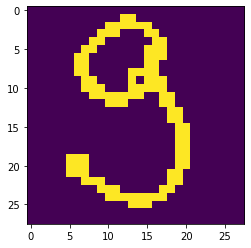

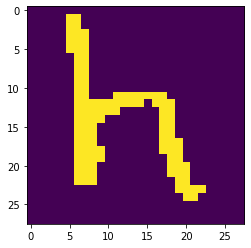

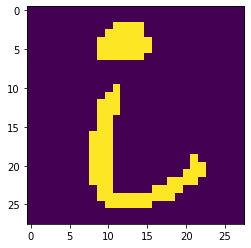

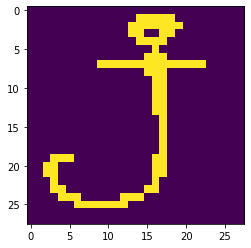

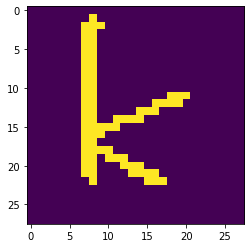

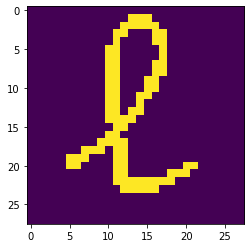

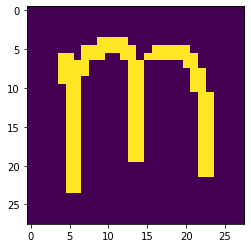

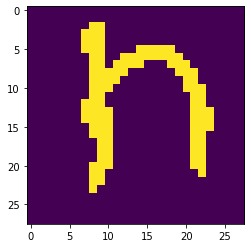

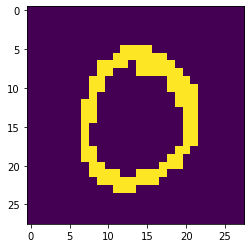

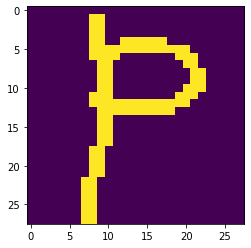

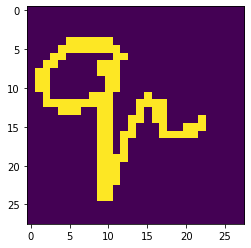

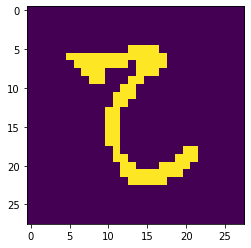

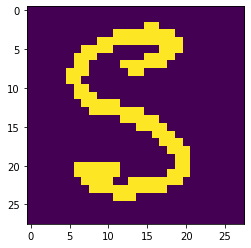

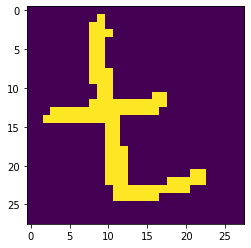

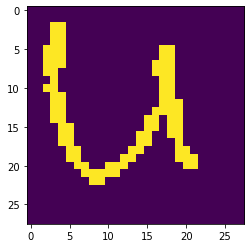

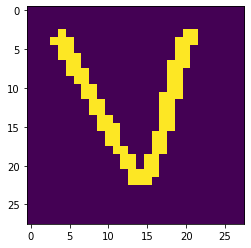

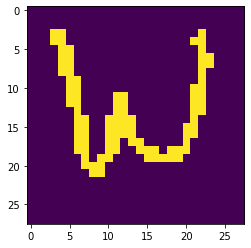

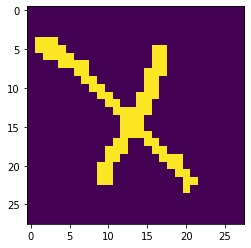

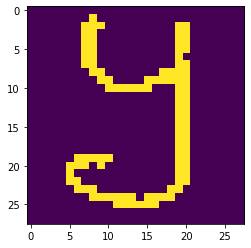

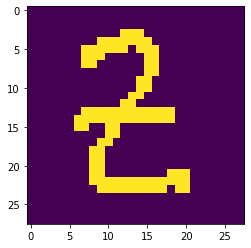

In [9]:
# Handwritten Testset 2 in order to further test our CNN
folderpath = '/content/drive/MyDrive/VisionDataset/CroppedHandwritten'
test2_dataset_temp = np.zeros((28,28,1), int)
test2_labels_temp = []

for filename in os.listdir(folderpath):
  infilename = os.path.join(folderpath,filename)
  if not os.path.isfile(infilename): continue #when the item in the folder is not a file => skip this one
  
  # Make an array that has the labels inside
  temp_label = infilename[-6].lower() #as the extension of all our images is .jpeg => -6 will give character to form labels (due to consistent naming of images) AND take the lowercase (needed for ord function in next line)
  test2_labels_temp.append(ord(temp_label)-96) #https://www.kite.com/python/answers/how-to-convert-letters-to-numbers-in-python #look at site => convert 'a' to 1 etc.

  img = Image.open(infilename)
  img_gray = ImageOps.grayscale(img) #https://www.geeksforgeeks.org/python-pil-imageops-greyscale-method/
  img_gray_rezised = img_gray.resize((28, 28), Image.ANTIALIAS)

  # pixel value needs to be normalized by dividing by 255
  pic = np.array(img_gray_rezised)
  # convert from integers to floats
  pic = pic.astype('float32')
  # take a threshold of the image
  pic[pic > 190] = 0 #when the pixel value is more than 150 => put pixel value to 255 in order to create more contrast
  pic[pic != 0] = 180 # the 5 letters Daria wrote for which we got 80% accuracy had 180 as value of non-zeros
  # normalize to the range 0-1
  pic /= 255.0
  plt.imshow(pic)
  plt.show()

  # Stack the 2D picture into the dataset, extending the numpy array in the third dimension
  test2_dataset_temp = np.dstack((test2_dataset_temp, pic))

# Transform into pytorch tensor
test2_labels = torch.tensor(test2_labels_temp)

# remove first image = needed to append 2D image to 3D one by selecting all remaining 2D images = length of labels there were
test2_dataset_cut = test2_dataset_temp[:,:,-len(test2_labels):] # as the numpy array is initialized outside the for loop, but the first slice stays. This cuts off the first slice, so we don't have an empty slice (this is not an image, but just due to initialization)
test2_dataset_newaxis = test2_dataset_cut[...,np.newaxis] # this initializes a new dimension that is needed to match the dimensions of the train and test dataset : dim = imagesx1x28x28
test2_dataset_transposed = test2_dataset_newaxis.transpose(-2,-1,0,1) # this function transposes the dimensions without altering the image (so image isn't distorted in any way) to have the same dimensions as train and test dataset (as appending is easier in another way, I kept the numpy array in the loop at a certain size)
test2_dataset = torch.from_numpy(test2_dataset_transposed).type(torch.float) #convert numpy array to pytorch tensor

# Test 3

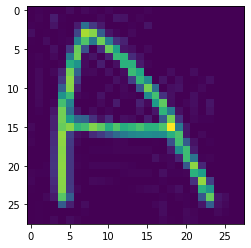

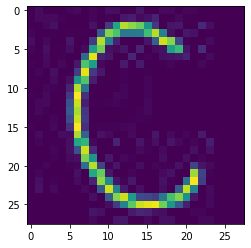

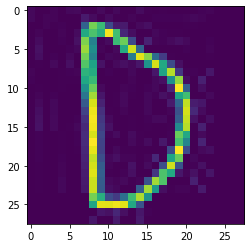

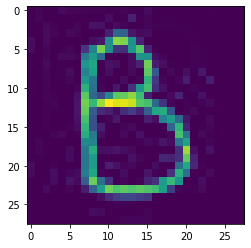

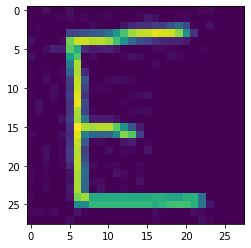

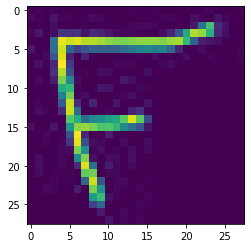

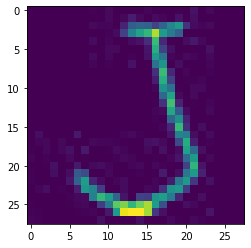

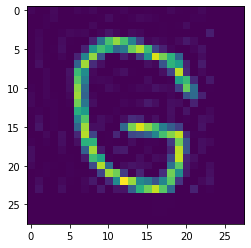

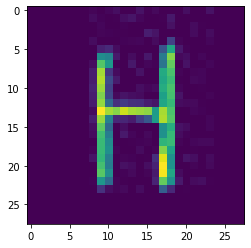

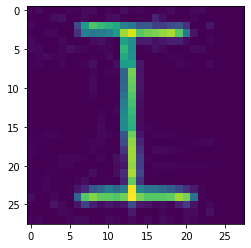

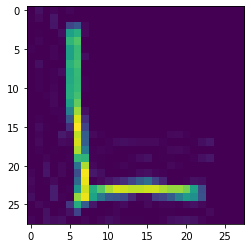

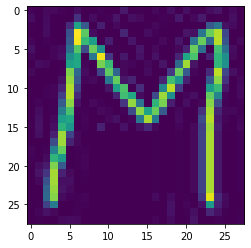

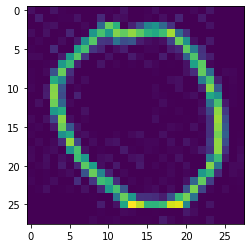

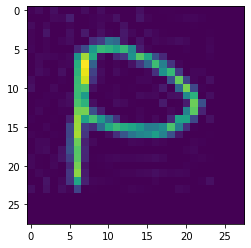

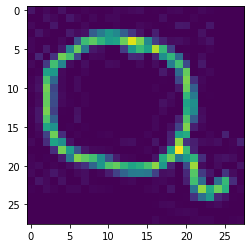

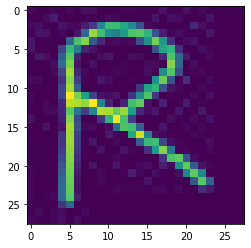

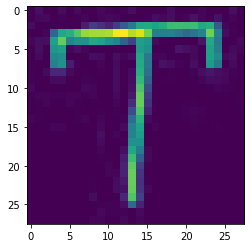

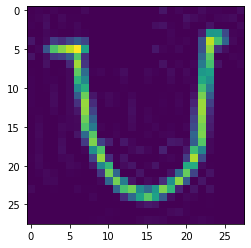

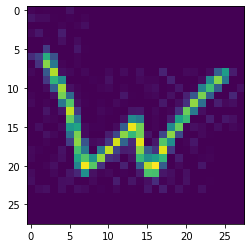

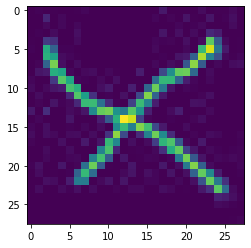

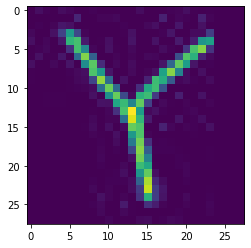

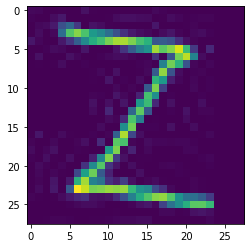

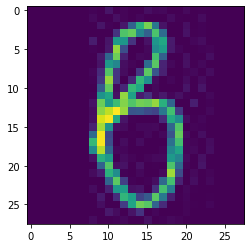

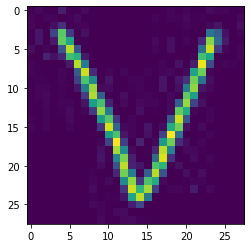

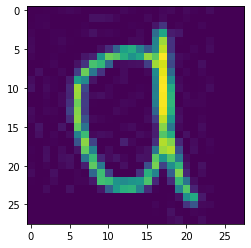

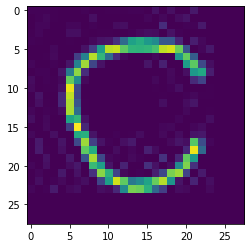

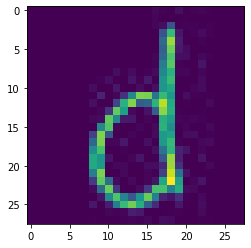

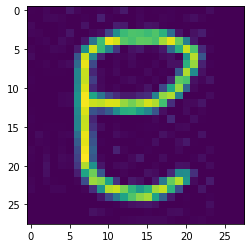

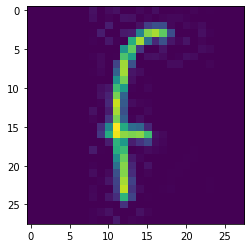

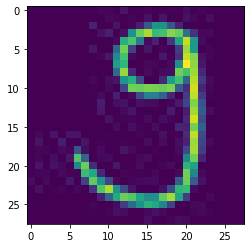

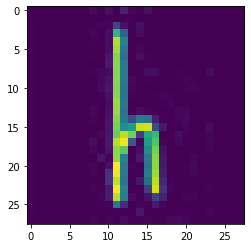

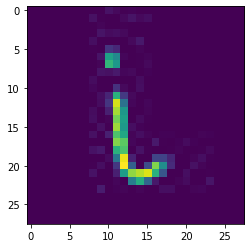

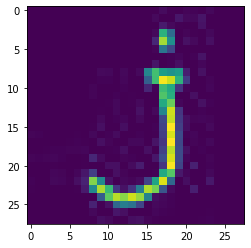

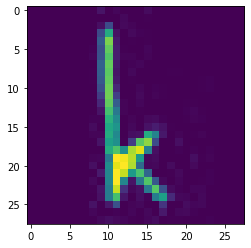

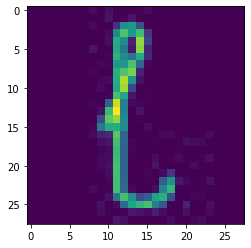

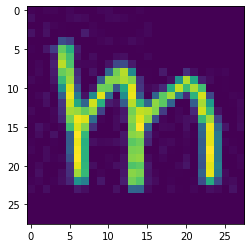

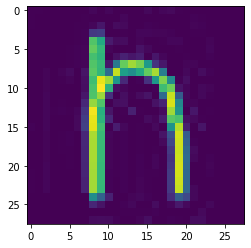

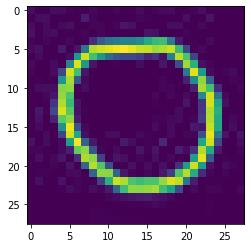

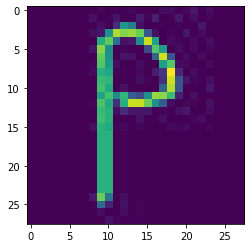

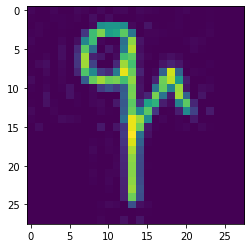

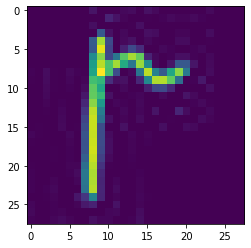

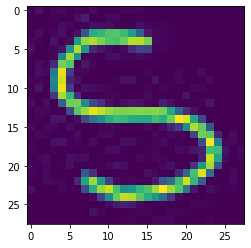

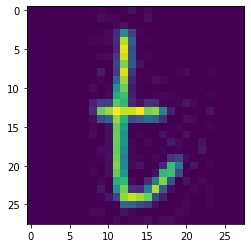

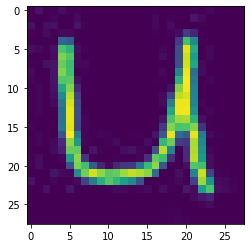

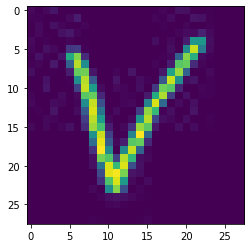

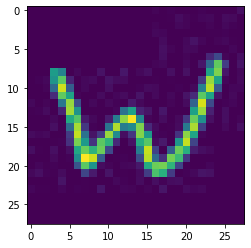

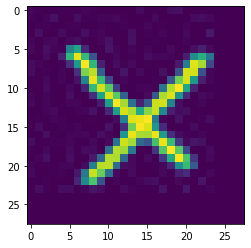

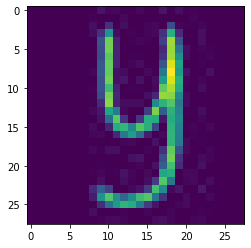

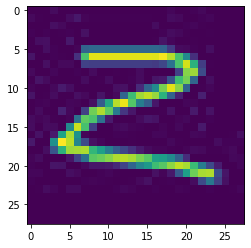

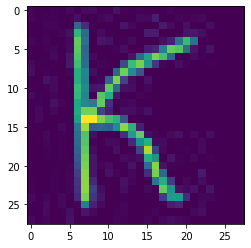

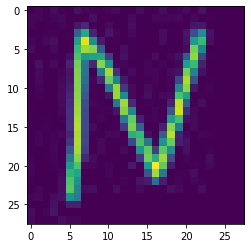

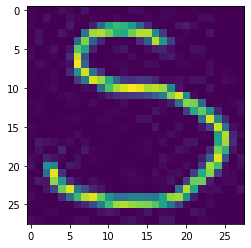

In [10]:
# Handwritten Testset 3 in order to further test our CNN
folderpath = '/content/drive/MyDrive/VisionDataset/Letters'
test3_dataset_temp = np.zeros((28,28,1), int)
test3_labels_temp = []

for filename in os.listdir(folderpath):
  infilename = os.path.join(folderpath,filename)
  if not os.path.isfile(infilename): continue #when the item in the folder is not a file => skip this one
  
  # Make an array that has the labels inside
  temp_label = infilename[-6].lower() #as the extension of all our images is .jpeg => -6 will give character to form labels (due to consistent naming of images) AND take the lowercase (needed for ord function in next line)
  test3_labels_temp.append(ord(temp_label)-96) #https://www.kite.com/python/answers/how-to-convert-letters-to-numbers-in-python #look at site => convert 'a' to 1 etc.

  img = Image.open(infilename)
  img_gray = ImageOps.grayscale(img) #https://www.geeksforgeeks.org/python-pil-imageops-greyscale-method/
  img_gray_rezised = img_gray.resize((28, 28), Image.ANTIALIAS)

  # pixel value needs to be normalized by dividing by 255
  pic = np.array(img_gray_rezised)
  # convert from integers to floats
  pic = pic.astype('float32')
  # normalize to the range 0-1
  pic /= 255.0
  plt.imshow(pic)
  plt.show()

  # Stack the 2D picture into the dataset, extending the numpy array in the third dimension
  test3_dataset_temp = np.dstack((test3_dataset_temp, pic))

# Transform into pytorch tensor
test3_labels = torch.tensor(test3_labels_temp)

# remove first image = needed to append 2D image to 3D one by selecting all remaining 2D images = length of labels there were
test3_dataset_cut = test3_dataset_temp[:,:,-len(test3_labels):] # as the numpy array is initialized outside the for loop, but the first slice stays. This cuts off the first slice, so we don't have an empty slice (this is not an image, but just due to initialization)
test3_dataset_newaxis = test3_dataset_cut[...,np.newaxis] # this initializes a new dimension that is needed to match the dimensions of the train and test dataset : dim = imagesx1x28x28
test3_dataset_transposed = test3_dataset_newaxis.transpose(-2,-1,0,1) # this function transposes the dimensions without altering the image (so image isn't distorted in any way) to have the same dimensions as train and test dataset (as appending is easier in another way, I kept the numpy array in the loop at a certain size)
test3_dataset = torch.from_numpy(test3_dataset_transposed).type(torch.float) #convert numpy array to pytorch tensor

# PyTorch Tensors

In [11]:
#Shuffling datasets
def shuffleDataset(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
    
x_train, y_train = shuffleDataset(x_train, y_train)
x_test, y_test = shuffleDataset(x_test, y_test)
test2_dataset, test2_labels = shuffleDataset(test2_dataset, test2_labels)
test3_dataset, test3_labels = shuffleDataset(test3_dataset, test3_labels)

In [12]:
#Making Pytorch tensors
X_train = torch.tensor(x_train[:25000], dtype=torch.float)
Y_train = torch.tensor(y_train[:25000])
X_val = torch.tensor(x_test[:6000], dtype=torch.float)
Y_val = torch.tensor(y_test[:6000])
X_test = torch.tensor(x_test[6000:12000], dtype=torch.float)
Y_test = torch.tensor(y_test[6000:12000])
X_test2 = torch.tensor(test2_dataset, dtype=torch.float)
Y_test2 = torch.tensor(test2_labels)
X_test3 = torch.tensor(test3_dataset, dtype=torch.float)
Y_test3 = torch.tensor(test3_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to u

# CNN architecture

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features             
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])

In [14]:
class CNN(nn.Module):

    def __init__(self, num_classes=27):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.drop = nn.Dropout(p=0.2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32*4*4,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,num_classes)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv(x))
        x = self.pool(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.drop(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
        cnn = CNN()

In [15]:
def get_predictions(model,data):
    return model(data).numpy().argmax(axis=1)    
def compute_accuracy(predictions,ground_truth):
    return (predictions == ground_truth.numpy()).mean()

In [16]:
def train_CNN(model,optimizer,learning_rate,num_epochs):
  model = CNN()

  criterion = torch.nn.CrossEntropyLoss()

  optimizer = optimizer(model.parameters(),lr=learning_rate)
  batch_size = 500

  train_dataset = Dataset(X_train, Y_train)
  dataloader = torch.utils.data.DataLoader(train_dataset,
                                       batch_size=batch_size,
                                       shuffle=True)

  total_step = len(dataloader)
  val_accs = np.zeros(num_epochs)
  
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(dataloader):
      model.zero_grad()
        
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

    with torch.no_grad():
      model.eval()
      pred_train = get_predictions(model,X_train)       
      train_acc = compute_accuracy(pred_train, Y_train) 
      print("For Epooch: {}".format(epoch))
      print("Training accuracy: {}".format(train_acc))  
      pred_val = get_predictions(model,X_val)     
      val_acc = compute_accuracy(pred_val, Y_val)
      val_accs[epoch]=val_acc
      print("Validation accuracy: {}".format(val_acc))
      print("Validation Loss : {}".format(1-val_acc))

  with torch.no_grad():
    model.eval()  
    pred_test = get_predictions(model,X_test)
    test_acc = compute_accuracy(pred_test, Y_test)
    prob_test = model(X_test)

  with torch.no_grad():
    model.eval()  
    pred_test2 = get_predictions(model,X_test2)
    test2_acc = compute_accuracy(pred_test2, Y_test2)
    prob_test2 = model(X_test2)

  with torch.no_grad():
    model.eval()  
    pred_test3 = get_predictions(model,X_test3)
    test3_acc = compute_accuracy(pred_test3, Y_test3)
    prob_test3 = model(X_test3)


  return val_accs, pred_test, test_acc, prob_test, pred_test2, test2_acc, prob_test2, pred_test3, test3_acc, prob_test3

# Validation accuracy

For Epooch: 0
Training accuracy: 0.64908
Validation accuracy: 0.6496666666666666
Validation Loss : 0.3503333333333334
For Epooch: 1
Training accuracy: 0.77136
Validation accuracy: 0.7653333333333333
Validation Loss : 0.2346666666666667
For Epooch: 2
Training accuracy: 0.832
Validation accuracy: 0.823
Validation Loss : 0.17700000000000005
For Epooch: 3
Training accuracy: 0.8542
Validation accuracy: 0.8443333333333334
Validation Loss : 0.15566666666666662
For Epooch: 4
Training accuracy: 0.88792
Validation accuracy: 0.8686666666666667
Validation Loss : 0.1313333333333333
For Epooch: 5
Training accuracy: 0.89944
Validation accuracy: 0.8763333333333333
Validation Loss : 0.1236666666666667
For Epooch: 6
Training accuracy: 0.90732
Validation accuracy: 0.8836666666666667
Validation Loss : 0.11633333333333329
For Epooch: 7
Training accuracy: 0.91316
Validation accuracy: 0.8885
Validation Loss : 0.11150000000000004
For Epooch: 8
Training accuracy: 0.9194
Validation accuracy: 0.8898333333333334


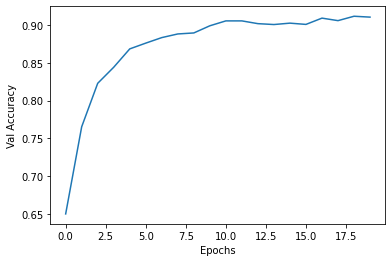

In [17]:
optimizer=torch.optim.Adam

val_accs, pred_test, test_acc, prob_test, pred_test2, test2_acc, prob_test2, pred_test3, test3_acc, prob_test3 = train_CNN(CNN,optimizer,0.001,20)
plt.plot(val_accs)  
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

## F1, recall, precision scores

In [18]:
Y_testarray = Y_test.numpy()
Y_testarray2 = Y_test2.numpy()
Y_testarray3 = Y_test3.numpy()

In [19]:
#Evaluation scores
numbofClasses = 27
from sklearn.metrics import classification_report
print(classification_report(Y_testarray,pred_test,zero_division=1))
print(classification_report(Y_testarray2,pred_test2,zero_division=1))
print(classification_report(Y_testarray3,pred_test3,zero_division=1))

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       233
           2       0.97      0.94      0.96       219
           3       0.97      0.95      0.96       235
           4       0.94      0.88      0.91       252
           5       0.95      0.95      0.95       225
           6       0.96      0.95      0.95       220
           7       0.83      0.81      0.82       248
           8       0.93      0.96      0.94       226
           9       0.74      0.74      0.74       219
          10       0.96      0.94      0.95       226
          11       0.99      0.92      0.95       238
          12       0.74      0.77      0.75       210
          13       0.97      0.97      0.97       229
          14       0.94      0.91      0.92       248
          15       0.90      0.98      0.93       255
          16       0.98      0.96      0.97       235
          17       0.76      0.85      0.80       236
          18       0.94    

In [20]:
#Averaged evaluation scores
from sklearn.metrics import f1_score,recall_score,precision_score
f1_scores = f1_score(Y_test,pred_test,average="weighted") 
recall_scores = recall_score(Y_test,pred_test,average="weighted",zero_division=1) 
precision_scores = precision_score(Y_test,pred_test,average="weighted") 
print("F1_score: {}".format(f1_scores))
print("Recall_score: {}".format(recall_scores))
print("Precision_score: {}".format(precision_scores))

#Averaged evaluation scores handwritten dataset "test 2"
f1_scores_t2 = f1_score(Y_test2,pred_test2,average="weighted")
recall_scores_t2 = recall_score(Y_test2,pred_test2,average="weighted",zero_division=1)
precision_scores_t2 = precision_score(Y_test2,pred_test2,average="weighted")
print("F1_score of Handwritten dataset: {}".format(f1_scores_t2))
print("Recall_score of Handwritten dataset: {}".format(recall_scores_t2))
print("Precision_score of Handwritten dataset: {}".format(precision_scores_t2))

#Averaged evaluation scores computer generated handwritten dataset "test 3"
f1_scores_t3 = f1_score(Y_test3,pred_test3,average="weighted")
recall_scores_t3 = recall_score(Y_test3,pred_test3,average="weighted",zero_division=1)
precision_scores_t3 = precision_score(Y_test3,pred_test3,average="weighted")
print("F1_score of computer generated Handwritten dataset: {}".format(f1_scores_t3))
print("Recall_score of computer generated Handwritten dataset: {}".format(recall_scores_t3))
print("Precision_score of computer generated Handwritten dataset: {}".format(precision_scores_t3))

F1_score: 0.9188186584151179
Recall_score: 0.9183333333333333
Precision_score: 0.9203271082342174
F1_score of Handwritten dataset: 0.8282051282051283
Recall_score of Handwritten dataset: 0.8461538461538461
Precision_score of Handwritten dataset: 0.8717948717948717
F1_score of computer generated Handwritten dataset: 0.8527472527472528
Recall_score of computer generated Handwritten dataset: 0.8653846153846154
Precision_score of computer generated Handwritten dataset: 0.8743589743589744


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion matrix

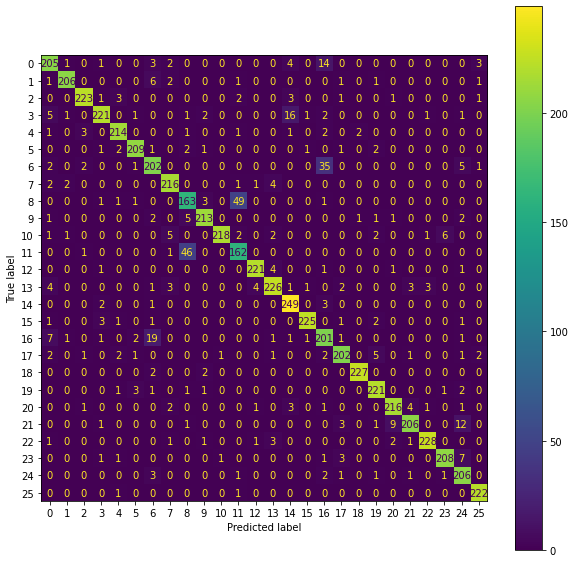

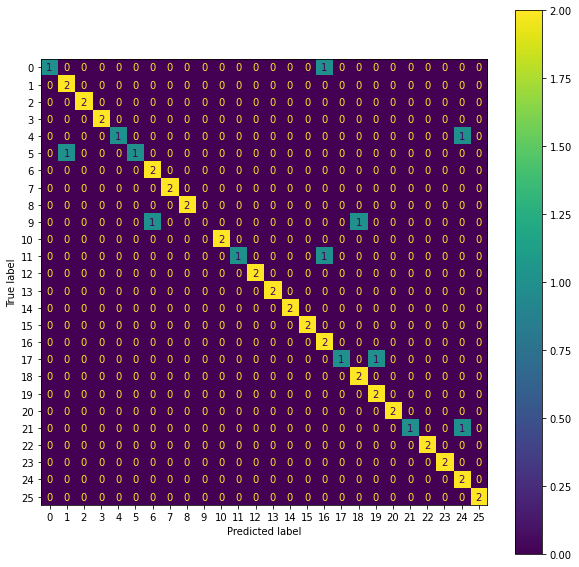

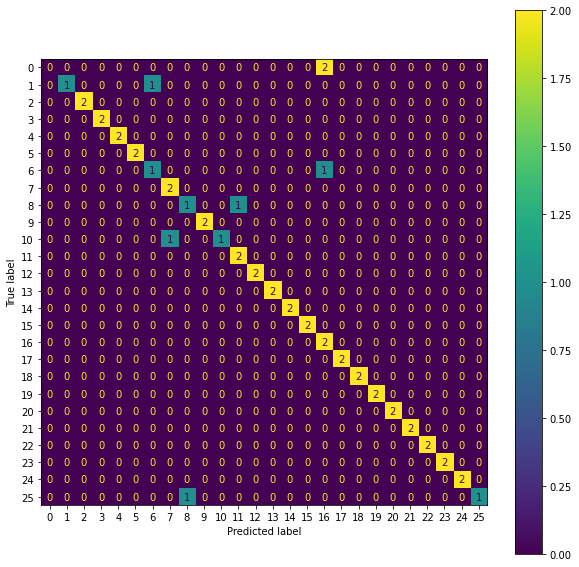

In [21]:
#Confusion Matrix
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn 

cm = confusion_matrix(Y_test,pred_test)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

cm2 = confusion_matrix(Y_test2,pred_test2) 
cmp = ConfusionMatrixDisplay(confusion_matrix=cm2)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

cm3 = confusion_matrix(Y_test3,pred_test3) 
cmp = ConfusionMatrixDisplay(confusion_matrix=cm3)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)